# Trying to figure out what the prior should be. 

In this notebook I will first explore how sensitive the results are to the prior by testing how the velocity distributions change with four priors:

1. An uninformative prior.
2. A prior constructed from the brightest stars.
3. A prior constructed from the faintest stars.
4. A prior constructed from all stars.

These priors need to be created using robust estimates of the mean and covariance of velocities, so I'll need to sigma clip to calculate those.

I also need to check that it does actually make sense to have a multivariate Gaussian prior that includes distance.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
import aviary as av
import astropy.stats as aps
import starspot as ss

Load velocity file.

In [2]:
with fits.open("../../data/kepler_dr2_1arcsec.fits") as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")
    
m = gaia.parallax.values > 0
gaia = gaia.iloc[m]

santos = pd.read_csv("../../data/santos.csv", skiprows=41)
santos["kepid"] = santos.KIC

mc1 = pd.read_csv("../../data/Table_1_Periodic.txt")
mc1["kepid"] = mc1.KID.values

mc_santos = pd.merge(santos, mc1, how="outer", on="kepid", suffixes=["_santos", "_mcquillan"])

mc_sant_gaia = pd.merge(mc_santos, gaia, how="left", on="kepid", suffixes=["KIC", ""])
df0 = mc_sant_gaia.drop_duplicates(subset="kepid")

lamost = pd.read_csv("../../data/KeplerRot-LAMOST.csv")
lamost["kepid"] = lamost.KIC.values
lam = pd.merge(df0, lamost, on="kepid", how="left", suffixes=["", "_lamost"])
df = lam.drop_duplicates(subset="kepid")
print(np.shape(df))

(38710, 157)


Which RVs are better? Gaia or Lamost? -- Gaia.

4.73073


/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


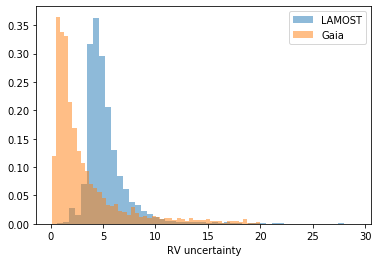

In [3]:
plt.hist(df.e_RV_lam[(df.e_RV_lam < 30) * (.1 < df.e_RV_lam)], 50, density=True, alpha=.5, label="LAMOST");
print(np.median(df.e_RV_lam.values[np.isfinite(df.e_RV_lam.values)]))

plt.hist(df.radial_velocity_error.values, 50, density=True, alpha=.5, label="Gaia");
plt.legend();
plt.xlabel("RV uncertainty");

Keep Gaia RVs, replace Lamost.

In [4]:
rv, rv_err = df.RV_lam.values, df.e_RV_lam.values
m = (df.radial_velocity.values != 0) * np.isfinite(df.radial_velocity.values)
rv[m], rv_err[m] = df.radial_velocity.values[m], df.radial_velocity_error.values[m]
df["rv"] = rv
df["rv_err"] = rv_err

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Calculate velocities.

In [5]:
xyz, vxyz = av.simple_calc_vxyz(df.ra.values, df.dec.values, 1./df.parallax.values,
                                df.pmra.values, df.pmdec.values, df.rv.values)
vx, vy, vz = vxyz[0, :].value, vxyz[1, :].value, vxyz[2, :].value

Save file.

In [6]:
df["vx"] = vx
df["vy"] = vy
df["vz"] = vz

df.to_csv("../../data/mcquillan_santos_gaia_lamost_velocities.csv")

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

Apply sigma clipping.

In [48]:
finite = np.isfinite(vx) * np.isfinite(vy) * np.isfinite(vz)
nsigma = 3
mx = ss.sigma_clip(vx[finite], nsigma=nsigma)
my = ss.sigma_clip(vx[finite], nsigma=nsigma)
mz = ss.sigma_clip(vx[finite], nsigma=nsigma)
m = mx & my & mz
print(len(vx[np.isfinite(vx)]), sum(m))

11614 11432


In [49]:
vx_c, vy_c, vz_c = vx[finite][m], vy[finite][m], vz[finite][m]

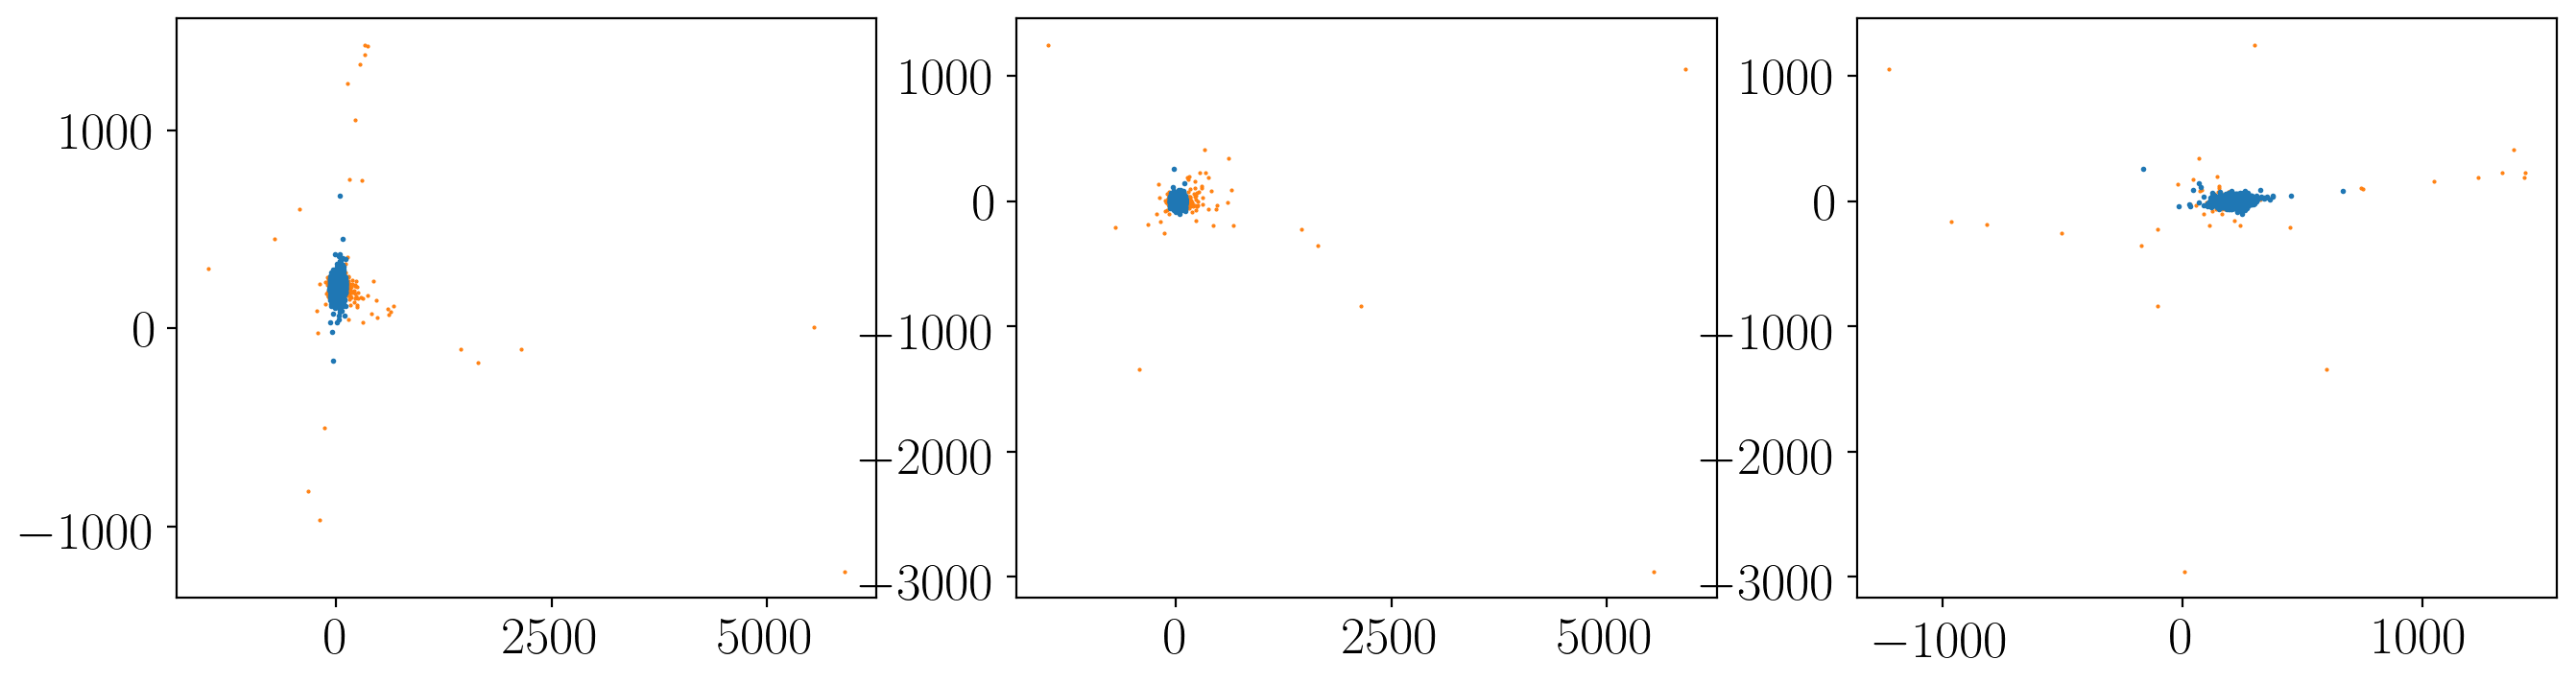

In [50]:
fig = plt.figure(figsize=(16, 4), dpi=200)
ax0 = fig.add_subplot(131)
ax0.plot(vx, vy, "C1.", alpha=1, ms=1)
ax0.plot(vx_c, vy_c, "C0.", alpha=1, ms=2)
ax1 = fig.add_subplot(132)
ax1.plot(vx, vz, "C1.", alpha=1, ms=1)
ax1.plot(vx_c, vz_c, "C0.", alpha=1, ms=2)
ax2 = fig.add_subplot(133)
ax2.plot(vy, vz, "C1.", alpha=1, ms=1)
ax2.plot(vy_c, vz_c, "C0.", alpha=1, ms=2)

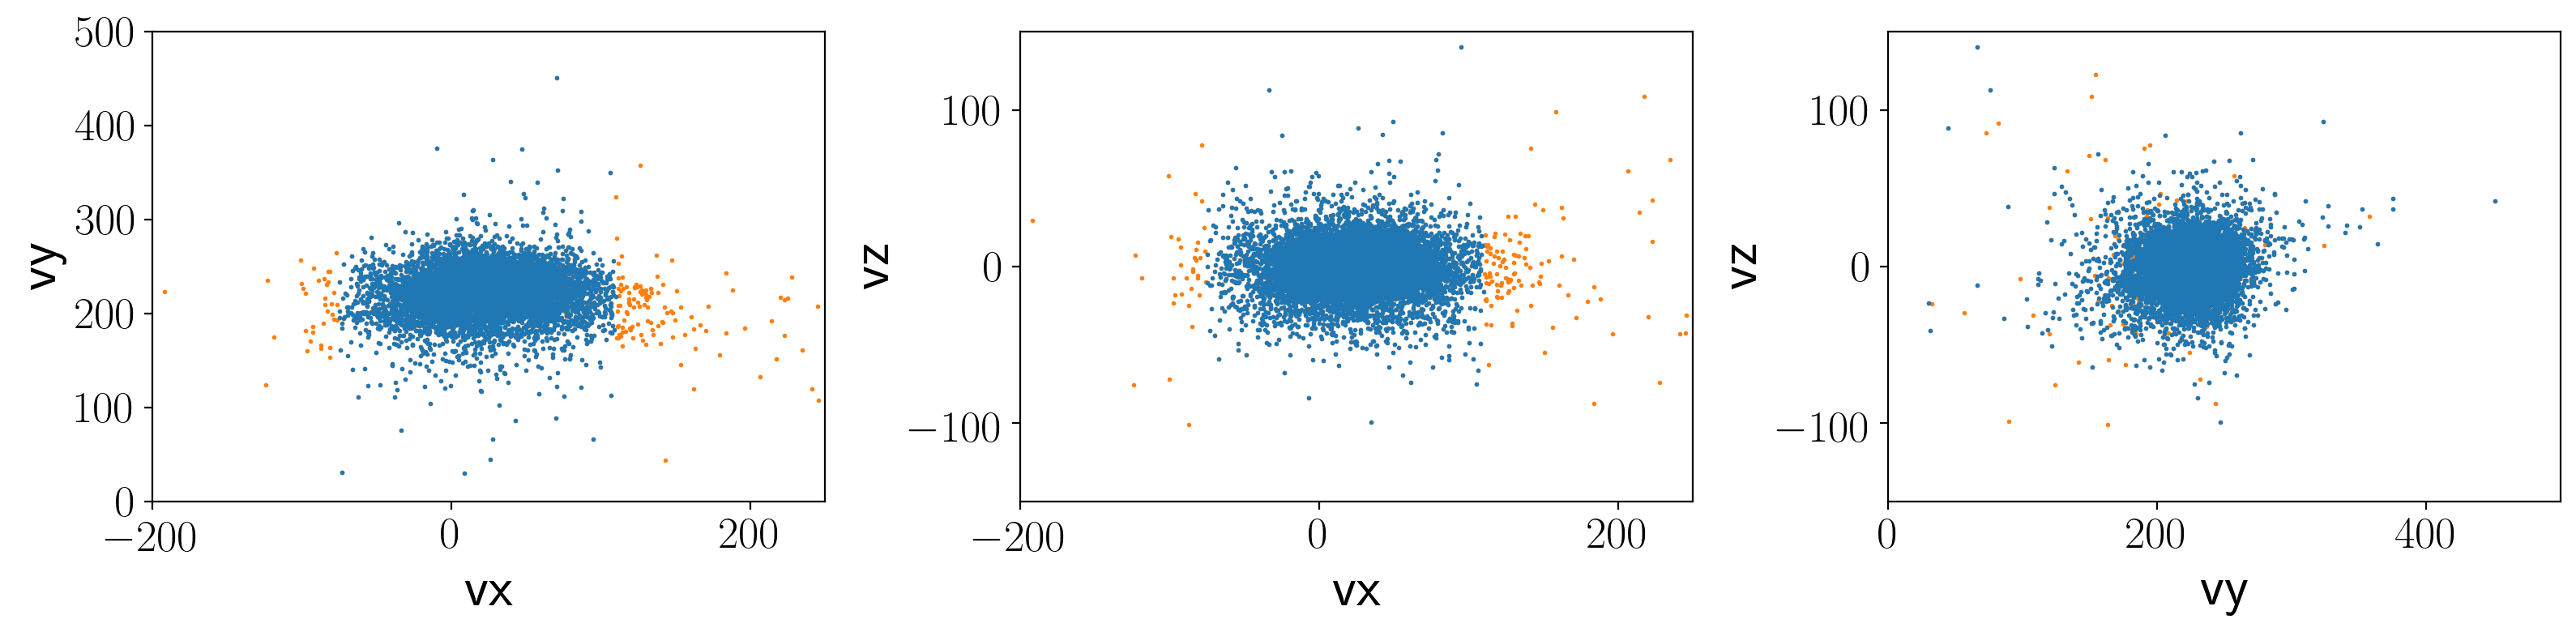

In [51]:
fig = plt.figure(figsize=(16, 4), dpi=200)
ax0 = fig.add_subplot(131)
ax0.plot(vx, vy, "C1.", alpha=1, ms=2)
ax0.plot(vx_c, vy_c, "C0.", alpha=1, ms=2)
ax0.set_xlim(-200, 250)
ax0.set_ylim(0, 500)
ax0.set_xlabel("vx")
ax0.set_ylabel("vy")
ax1 = fig.add_subplot(132)
ax1.plot(vx, vz, "C1.", alpha=1, ms=2)
ax1.plot(vx_c, vz_c, "C0.", alpha=1, ms=2)
ax1.set_xlim(-200, 250)
ax1.set_ylim(-150, 150)
ax1.set_xlabel("vx")
ax1.set_ylabel("vz")
ax2 = fig.add_subplot(133)
ax2.plot(vy, vz, "C1.", alpha=1, ms=2)
ax2.plot(vy_c, vz_c, "C0.", alpha=1, ms=2)
ax2.set_xlim(0, 500)
ax2.set_ylim(-150, 150)
ax2.set_xlabel("vy")
ax2.set_ylabel("vz")
plt.tight_layout()

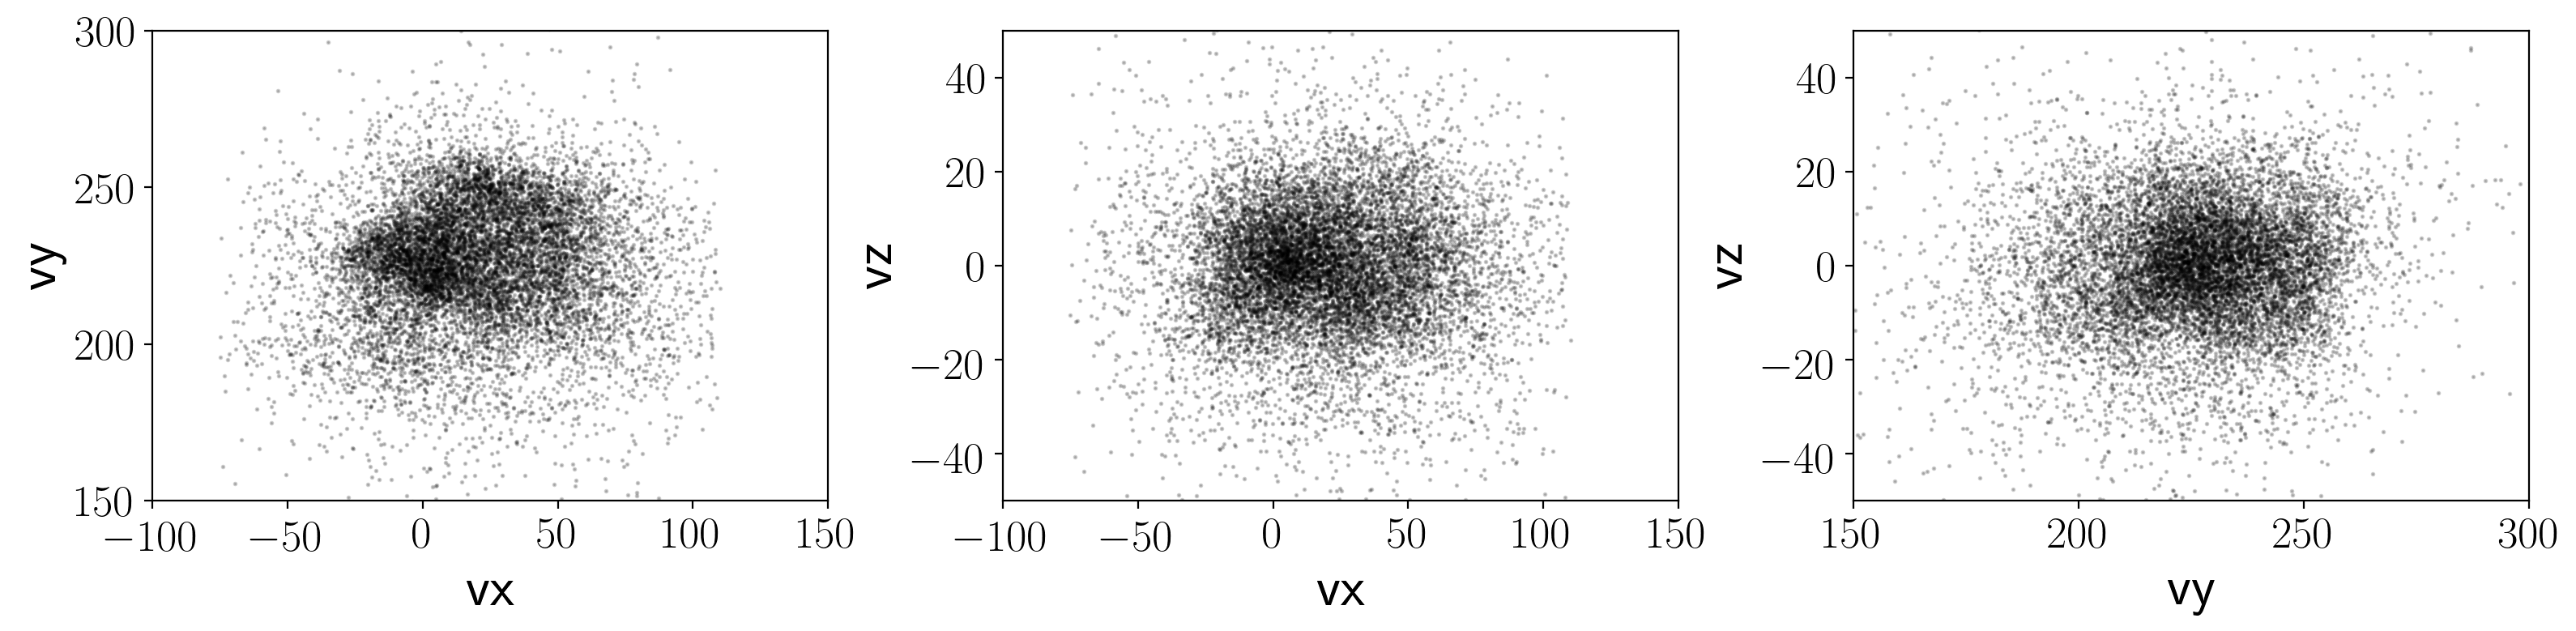

In [52]:
fig = plt.figure(figsize=(16, 4), dpi=200)
ax0 = fig.add_subplot(131)
ax0.plot(vx_c, vy_c, "k.", alpha=.2, ms=2)
ax0.set_xlim(-100, 150)
ax0.set_ylim(150, 300)
ax0.set_xlabel("vx")
ax0.set_ylabel("vy")
ax1 = fig.add_subplot(132)
ax1.plot(vx_c, vz_c, "k.", alpha=.2, ms=2)
ax1.set_xlim(-100, 150)
ax1.set_ylim(-50, 50)
ax1.set_xlabel("vx")
ax1.set_ylabel("vz")
ax2 = fig.add_subplot(133)
ax2.plot(vy_c, vz_c, "k.", alpha=.2, ms=2)
ax2.set_xlim(150, 300)
ax2.set_ylim(-50, 50)
ax2.set_xlabel("vy")
ax2.set_ylabel("vz")
plt.tight_layout()

In [53]:
V = np.stack((vx_c, vy_c, vz_c), axis=0)
mu, cov = np.mean(V, axis=1), np.cov(V)

V_full = np.stack((vx[finite], vy[finite], vz[finite]), axis=0)
muf, covf = np.mean(V_full, axis=1), np.cov(V_full)

Now repeat with distance too.

In [122]:
lnD = np.log(1./df.parallax)
finite = np.isfinite(vx) & np.isfinite(vy) & np.isfinite(vz) & np.isfinite(lnD)
nsigma = 3
mx = ss.sigma_clip(vx[finite], nsigma=nsigma)
my = ss.sigma_clip(vx[finite], nsigma=nsigma)
mz = ss.sigma_clip(vx[finite], nsigma=nsigma)
md = ss.sigma_clip(lnD[finite], nsigma=nsigma)
m = mx & my & mz & md

vx_c, vy_c, vz_c, lnD_c = vx[finite][m], vy[finite][m], vz[finite][m], lnD[finite][m]
print(len(vx[np.isfinite(vx)]), sum(m))

11614 11348


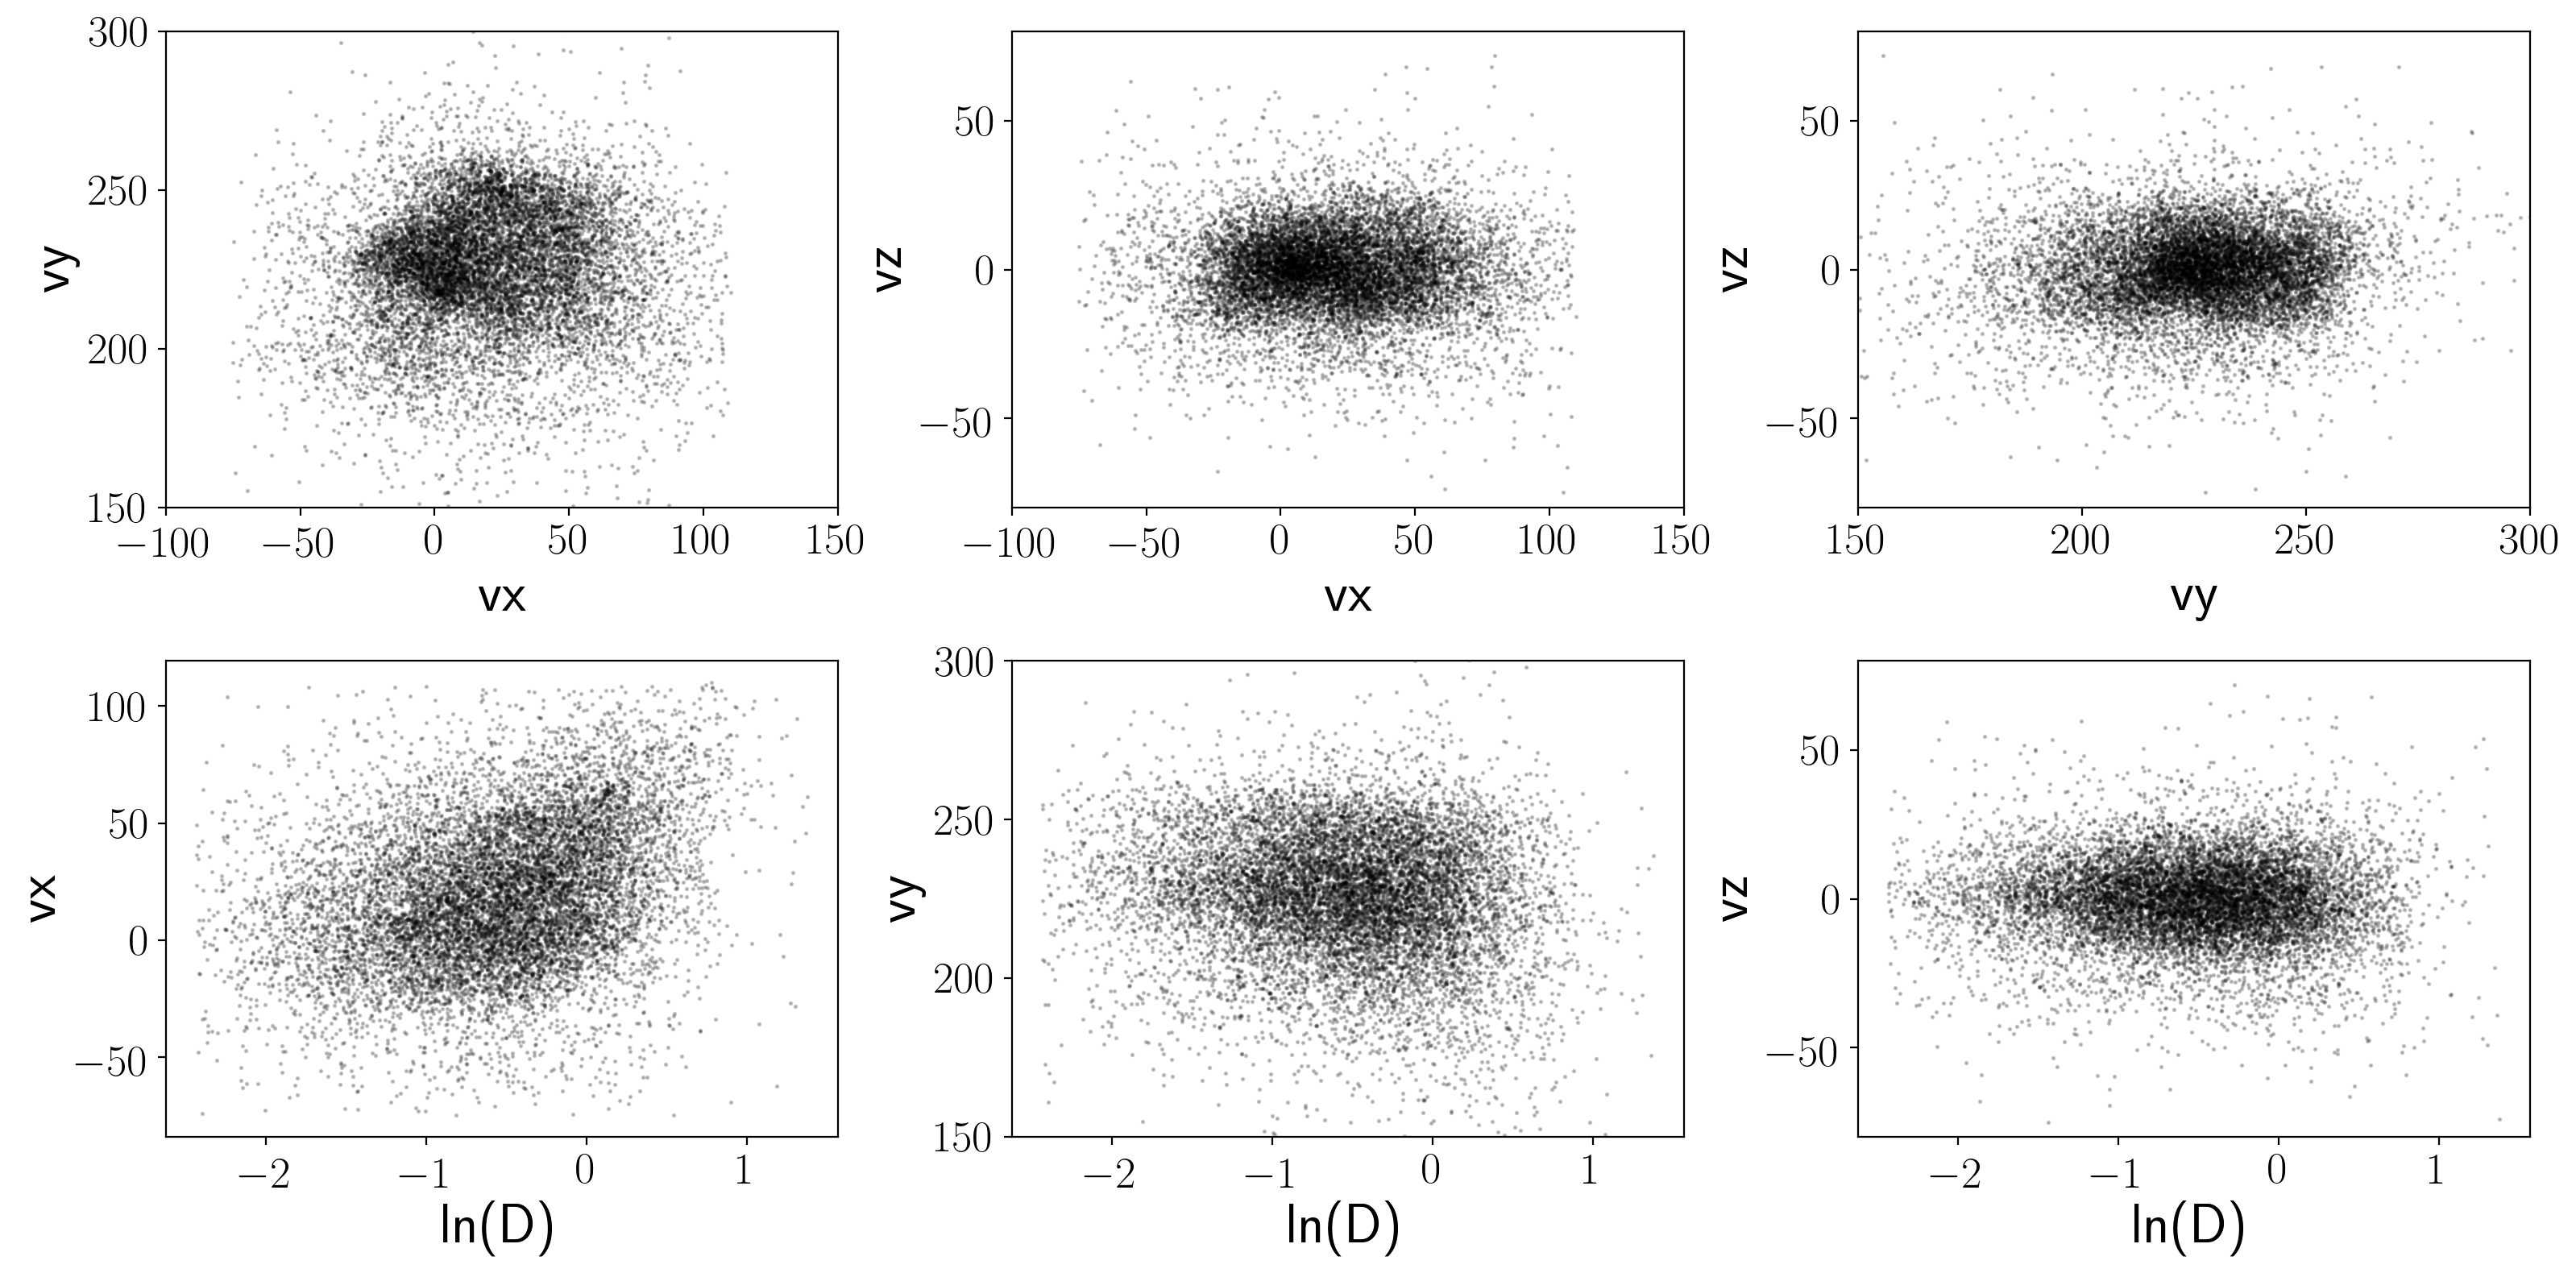

In [59]:
fig = plt.figure(figsize=(16, 8), dpi=200)
ax0 = fig.add_subplot(231)
ax0.plot(vx_c, vy_c, "k.", alpha=.2, ms=2)
ax0.set_xlim(-100, 150)
ax0.set_ylim(150, 300)
ax0.set_xlabel("vx")
ax0.set_ylabel("vy")
ax1 = fig.add_subplot(232)
ax1.plot(vx_c, vz_c, "k.", alpha=.2, ms=2)
ax1.set_xlim(-100, 150)
ax1.set_ylim(-80, 80)
ax1.set_xlabel("vx")
ax1.set_ylabel("vz")
ax2 = fig.add_subplot(233)
ax2.plot(vy_c, vz_c, "k.", alpha=.2, ms=2)
ax2.set_xlim(150, 300)
ax2.set_ylim(-80, 80)
ax2.set_xlabel("vy")
ax2.set_ylabel("vz")
ax3 = fig.add_subplot(234)
ax3.plot(lnD_c, vx_c, "k.", alpha=.2, ms=2)
ax3.set_ylabel("vx")
ax3.set_xlabel("ln(D)")
ax4 = fig.add_subplot(235)
ax4.plot(lnD_c, vy_c, "k.", alpha=.2, ms=2)
ax4.set_ylabel("vy")
ax4.set_xlabel("ln(D)")
ax4.set_ylim(150, 300)
ax5 = fig.add_subplot(236)
ax5.plot(lnD_c, vz_c, "k.", alpha=.2, ms=2)
ax5.set_ylabel("vz")
ax5.set_xlabel("ln(D)")
ax5.set_ylim(-80, 80)

plt.tight_layout()

Compare means and variances with medians and MADs to check they are similar.

Text(0.5, 0, 'vz')

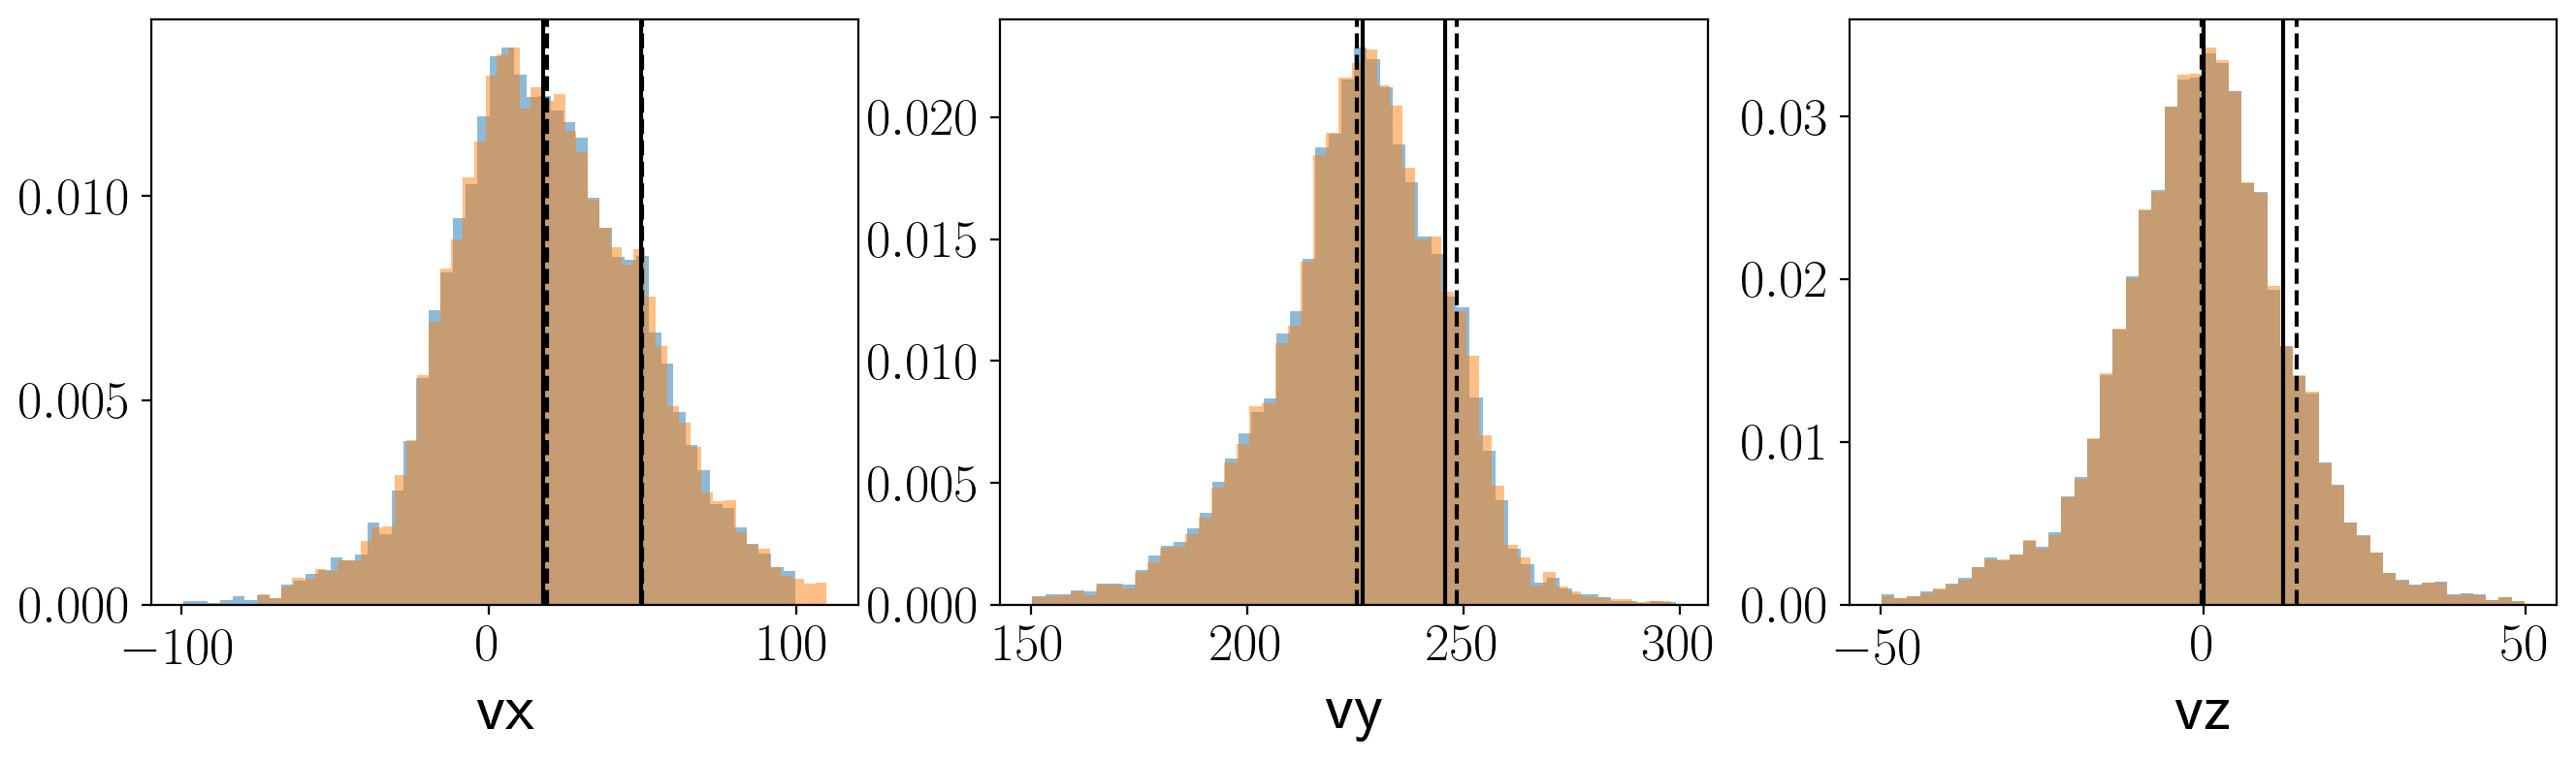

In [68]:
fig = plt.figure(figsize=(16, 4), dpi=200)
ax0 = fig.add_subplot(131)
ax0.hist(vx[finite][(-100 < vx[finite]) * (vx[finite] < 100)], 50, density=True, alpha=.5);
ax0.hist(vx_c, 50, density=True, alpha=.5);
ax0.axvline(np.median(vx[finite]), color="k")
ax0.axvline(mu[0], color="k", ls="--")
ax0.axvline(np.median(vx[finite]) + 1.5 * aps.median_absolute_deviation(vx[finite]), color="k")
ax0.axvline(mu[0] + np.sqrt(cov[0, 0]), color="k", ls="--")
ax0.set_xlabel("vx")

ax1 = fig.add_subplot(132)
ax1.hist(vy[finite][(150 < vy[finite]) * (vy[finite] < 300)], 50, density=True, alpha=.5);
ax1.hist(vy_c[(150 < vy_c) * (vy_c < 300)], 50, density=True, alpha=.5);
ax1.axvline(np.median(vy[finite]), color="k")
ax1.axvline(mu[1], color="k", ls="--")
ax1.axvline(np.median(vy[finite]) + 1.5 * aps.median_absolute_deviation(vy[finite]), color="k")
ax1.axvline(mu[1] + np.sqrt(cov[1, 1]), color="k", ls="--")
ax1.set_xlabel("vy")

ax2 = fig.add_subplot(133)
ax2.hist(vz[finite][(-50 < vz[finite]) * (vz[finite] < 50)], 50, density=True, alpha=.5);
ax2.hist(vz_c[(-50 < vz_c) * (vz_c < 50)], 50, density=True, alpha=.5);
ax2.axvline(np.median(vz[finite]), color="k")
ax2.axvline(mu[2], color="k", ls="--")
ax2.axvline(np.median(vz[finite]) + 1.5 * aps.median_absolute_deviation(vz[finite]), color="k")
ax2.axvline(mu[2] + np.sqrt(cov[2, 2]), color="k", ls="--")
ax2.set_xlabel("vz")

Now calculate the parameters of four priors: one calculated from faint stars only, one from bright stars only, one from all stars. Can I do another that is really uninformative?

Now do the whole thing from scratch.

In [150]:
df.to_csv("../../data/mcquillan_santos_gaia_lamost_velocities.csv")

lnD = np.log(1./df.parallax)
finite = np.isfinite(vx) & np.isfinite(vy) & np.isfinite(vz) & np.isfinite(lnD)
nsigma = 3
mx = ss.sigma_clip(vx[finite], nsigma=nsigma)
my = ss.sigma_clip(vx[finite], nsigma=nsigma)
mz = ss.sigma_clip(vx[finite], nsigma=nsigma)
md = ss.sigma_clip(lnD[finite], nsigma=nsigma)
m = mx & my & mz & md

gmag = df.phot_g_mean_mag.values[finite][m]
m_faint = gmag > 13.56
m_bright = gmag < 13.56

def mean_and_var(vx, vy, vz, lnD):
    V = np.stack((vx, vy, vz, lnD), axis=0)
    return np.mean(V, axis=1), np.cov(V)

mu_faint, cov_faint = mean_and_var(vx[finite][m][m_faint], vy[finite][m][m_faint], vz[finite][m][m_faint], lnD[finite][m][m_faint])
mu_bright, cov_bright = mean_and_var(vx[finite][m][m_bright], vy[finite][m][m_bright], vz[finite][m][m_bright], lnD[finite][m][m_bright])
mu_all, cov_all = mean_and_var(vx[finite][m], vy[finite][m], vz[finite][m], lnD[finite][m])

In [141]:
# V_faint = np.stack((vx[finite][m][m_faint], vy[finite][m][m_faint], vz[finite][m][m_faint]), axis=0)
# mu_faint, cov_faint = np.mean(V_faint, axis=1), np.cov(V_faint)

# V_bright = np.stack((vx[finite][m][m_bright], vy[finite][m][m_bright], vz[finite][m][m_bright]), axis=0)
# mu_bright, cov_bright = np.mean(V_bright, axis=1), np.cov(V_bright)

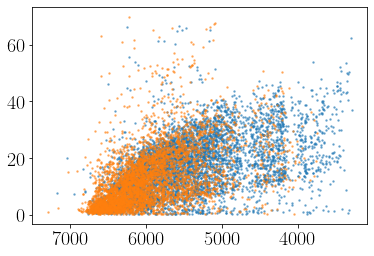

In [143]:
fig = plt.figure()
ax0 = fig.add_subplot(111)
ax0.plot(df.teff.values[finite][m][m_faint], df.Prot.values[finite][m][m_faint], ".", ms=3, alpha=.5)
ax0.plot(df.teff.values[finite][m][m_bright], df.Prot.values[finite][m][m_bright], ".", ms=3, alpha=.5)
ax0.invert_xaxis()

In [101]:
print(np.median(df.phot_g_mean_mag.values[(df.rv.values != 0) & np.isfinite(df.rv.values) & np.isfinite(df.phot_g_mean_mag.values)]))

13.566176414489746


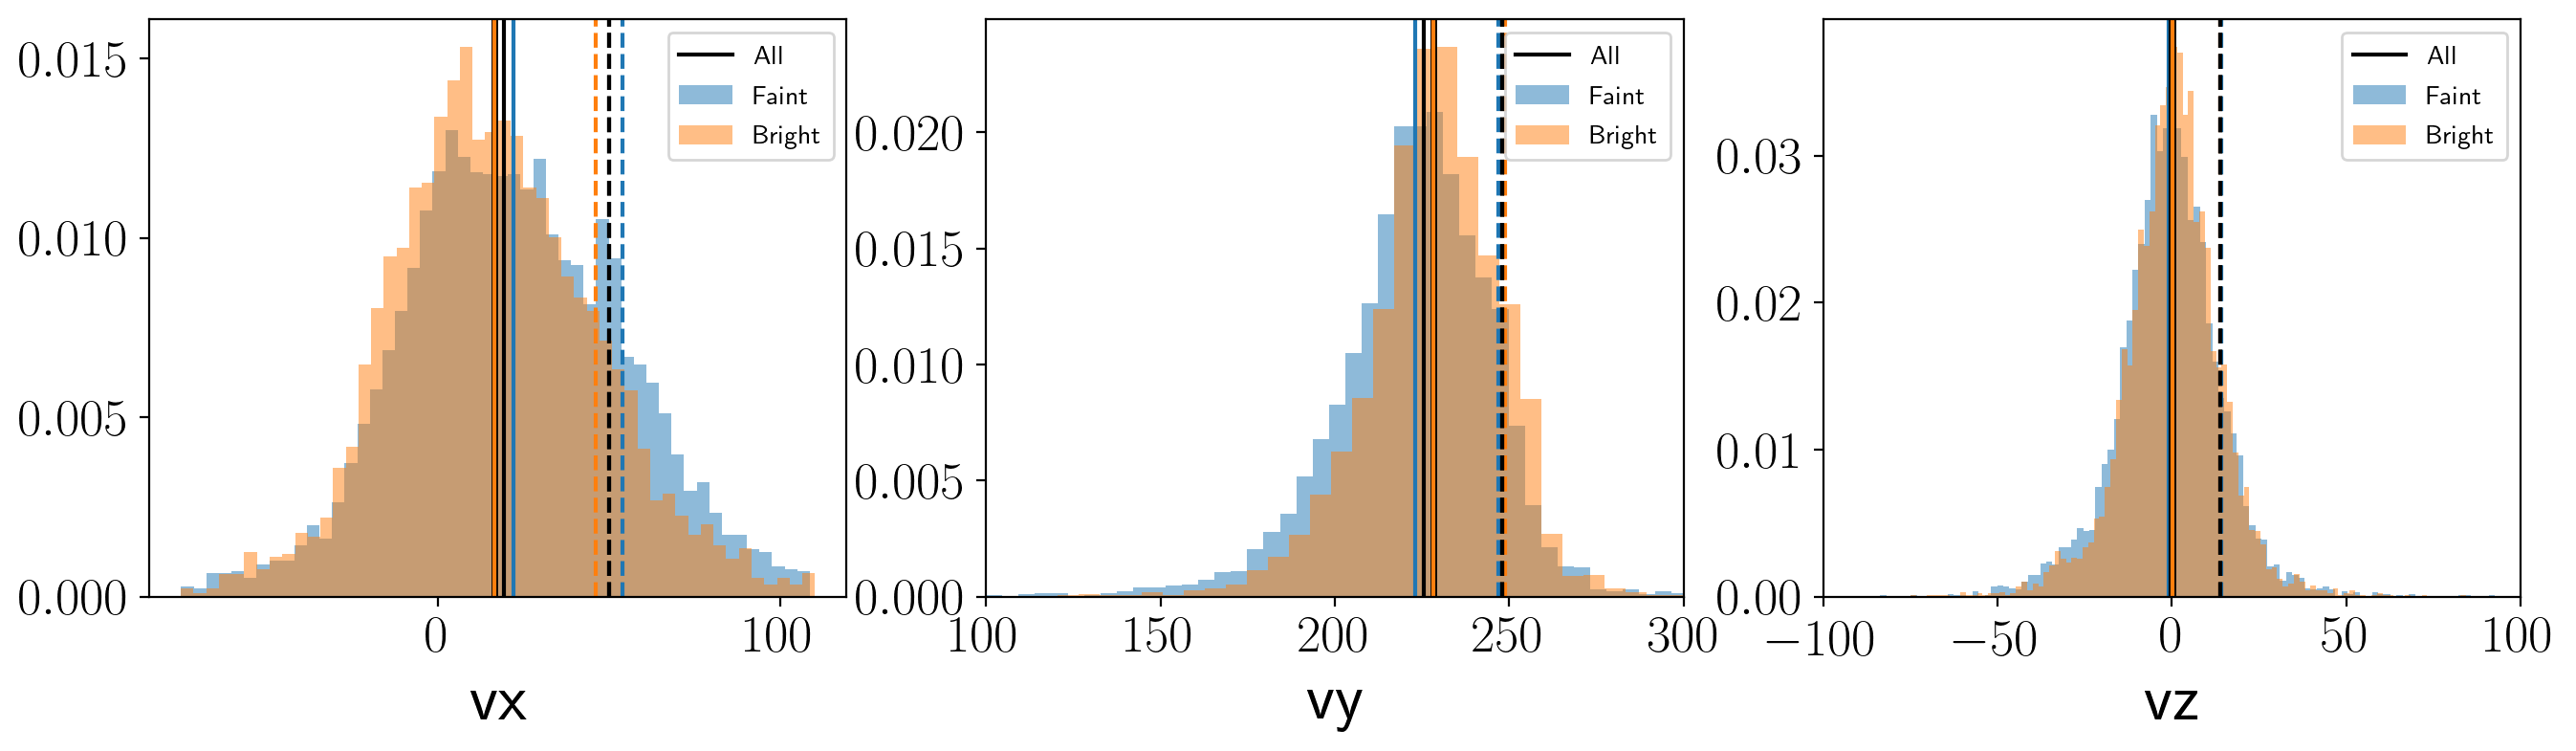

In [149]:
fig = plt.figure(figsize=(16, 4), dpi=200)
ax0 = fig.add_subplot(131)
ax0.hist(vx[finite][m][m_faint], 50, density=True, alpha=.5, label="Faint");
ax0.hist(vx[finite][m][m_bright], 50, density=True, alpha=.5, label="Bright");
ax0.axvline(np.mean(vx[finite][m][m_faint]), color="C0")
ax0.axvline(np.mean(vx[finite][m]), color="k", label="All")
ax0.axvline(np.mean(vx[finite][m][m_bright]), color="k", lw=2.5)
ax0.axvline(np.mean(vx[finite][m][m_bright]), color="C1")
ax0.axvline(np.mean(vx[finite][m][m_bright]) + np.sqrt(cov_bright[0, 0]), color="C1", ls="--")
ax0.axvline(np.mean(vx[finite][m][m_faint]) + np.sqrt(cov_faint[0, 0]), color="C0", ls="--")
ax0.axvline(np.mean(vx[finite][m]) + np.sqrt(cov_all[0, 0]), color="k", ls="--")
ax0.axvline(np.mean(vx[finite][m]) + np.sqrt(cov_all[0, 0]), color="k", ls="--")
ax0.legend()
ax0.set_xlabel("vx")

ax1 = fig.add_subplot(132)
ax1.hist(vy[finite][m][m_faint], 100, density=True, alpha=.5, label="Faint");
ax1.hist(vy[finite][m][m_bright], 100, density=True, alpha=.5, label="Bright");
ax1.axvline(np.mean(vy[finite][m][m_faint]), color="C0")
ax1.axvline(np.mean(vy[finite][m]), color="k", label="All")
ax1.axvline(np.mean(vy[finite][m][m_bright]), color="k", lw=2.5)
ax1.axvline(np.mean(vy[finite][m][m_bright]), color="C1")
ax1.axvline(np.mean(vy[finite][m][m_bright]) + np.sqrt(cov_bright[1, 1]), color="C1", ls="--")
ax1.axvline(np.mean(vy[finite][m][m_faint]) + np.sqrt(cov_faint[1, 1]), color="C0", ls="--")
ax1.axvline(np.mean(vy[finite][m]) + np.sqrt(cov_all[1, 1]), color="k", ls="--")
ax1.axvline(np.mean(vy[finite][m]) + np.sqrt(cov_all[1, 1]), color="k", ls="--")
ax1.legend()
ax1.set_xlabel("vy")
ax1.set_xlim(100, 300)

ax2 = fig.add_subplot(133)
ax2.hist(vz[finite][m][m_faint], 100, density=True, alpha=.5, label="Faint");
ax2.hist(vz[finite][m][m_bright], 100, density=True, alpha=.5, label="Bright");
ax2.axvline(np.mean(vz[finite][m][m_faint]), color="C0")
ax2.axvline(np.mean(vz[finite][m]), color="k", label="All")
ax2.axvline(np.mean(vz[finite][m][m_bright]), color="k", lw=2.5)
ax2.axvline(np.mean(vz[finite][m][m_bright]), color="C1")
ax2.axvline(np.mean(vz[finite][m][m_bright]) + np.sqrt(cov_bright[2, 2]), color="C1", ls="--")
ax2.axvline(np.mean(vz[finite][m][m_faint]) + np.sqrt(cov_faint[2, 2]), color="C0", ls="--")
ax2.axvline(np.mean(vz[finite][m]) + np.sqrt(cov_all[2, 2]), color="k", ls="--")
ax2.axvline(np.mean(vz[finite][m]) + np.sqrt(cov_all[2, 2]), color="k", ls="--")
ax2.legend()
ax2.set_xlabel("vz")
ax2.set_xlim(-100, 100);